# No More Alzheimer's Disease

## SVM Approach

### Data Downloading

In [105]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from timeit import default_timer as timer
import numpy as np

### Data Pre-Processing

Each necessary file is downloaded, unnecessary fields are removed and labels are assigned.

In [106]:

'''This function reads and does some pre-processing for the data files provided.'''

ugot = pd.read_csv("Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv")
# Read the labels that will be used for both of the files
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


#-------------------------UGOT------------------------------------------------------------------------
# Now merge these two files and remove any rows that have null values
ugot = pd.merge(ugot, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna(subset=['RID', 'PLASMAPTAU181', 'DX'])
# Update Stamp is not relevant for this test
ugot.drop(['update_stamp', 'VISCODE', 'VISCODE2', 'COMMENT', 'VID', 'EXAMDATE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
ugot = ugot.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
ugot.to_csv("Data/ProcessedData/UGOT.csv", index=False)

# -------------------------UPENN----------------------------------------------------------------------
upenn = pd.read_csv("Data/Plasma/UPENNPLASMA_27Nov2023.csv")
upenn = pd.merge(upenn, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
upenn.drop(['update_stamp', 'VISCODE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
upenn = upenn.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
upenn.to_csv("Data/ProcessedData/UPENN.csv", index=False)

# --------------------------ADNI_MERGE-----------------------------------------------------------------
adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")
adni_merge = adni_merge.loc[:, ~adni_merge.columns.str.endswith('_bl')]
adni_merge = adni_merge.loc[:, ['RID', 'DX', 'MMSE', 'AGE', 'PTAU', 'TAU', 'ABETA']]
regex_pattern = r'[<>](\d+)'

# This applies to all columns
adni_merge = adni_merge.apply(lambda col: col.astype(str).str.replace(regex_pattern, r'\1', regex=True))
adni_merge = adni_merge.replace('nan', np.nan).dropna()

#change to required format
adni_merge = adni_merge.replace("CN", "SCD").replace("Dementia", "AD")
adni_merge.to_csv("Data/ProcessedData/ADNIMerge.csv")

# --------------------------PLASMA_ABETA_PROJECT--------------------------------------------------------
p_ab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')
# Drop the VISCODE column and replace it with VISCODE2 (REFERENCE :: https://groups.google.com/g/adni-data/c/Dx_Rgge_XB0)
p_ab.drop('VISCODE', inplace=True, axis=1)
p_ab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
p_ab = pd.merge(p_ab, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
p_ab = p_ab.loc[:, ['RID', 'DX', 'SEQ', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
p_ab = p_ab.replace("CN", "SCD").replace('Dementia', 'AD')


p_ab.to_csv('Data/ProcessedData/Plasma_AB.csv')





/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_20275/1773404187.py:5: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_20275/1773404187.py:26: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")


### Construct the Classifier

In [107]:
def getXy(df):
    '''
    Seperate the label from the feature data.
    
    Args : 
        df (DataFrame) : The data to be seperated
    Returns :
        X (DataFrame) : The feature data.
        y (list) : The labels associated.'''
    
    # Independant
    X = df.drop("DX", axis=1).values
    # Dependant
    y = df["DX"].values

    return X, y

In [108]:
def get_different_classes(df):
    '''
        This function returns the three different classes, seperated into different dataframes.
        
        Args :
            df (DataFrame) : The dataframe containing all the label and feature data.
        Returns :
            SCD, MCI, AD : Each of the different labels (with the feature data) seperated into dataframes'''
    
    SCD = df.loc[df["DX"] == "SCD"]
    MCI = df.loc[df["DX"] == "MCI"]
    AD = df.loc[df["DX"] == "AD"]

    return SCD, MCI, AD

In [109]:
def split_test_data(SCD, MCI, AD, TestingFactor = 0.25):
    '''
        Now we seperate the training and testing data. Currently using a 25% training test split.

        Args : 
            SCD, MCI, AD (DataFrame) : Data to be split, already split into classes.
            TestingFactor (int) [OPTIONAL] : Amount of data put in testing.
        Returns :
            SCD, MCI, AD, TestData (DataFrame) : Each of the sections of data.
    
    '''

    SCD, TempSCD = train_test_split(SCD, test_size=TestingFactor)
    MCI, TempMCI = train_test_split(MCI, test_size=TestingFactor)
    AD, TempAD = train_test_split(AD, test_size=TestingFactor)

    # concatenate the lists
    TempData = [TempSCD, TempMCI, TempAD]
    TestData = pd.concat(TempData)

    # return required info
    return SCD, MCI, AD, TestData

In [110]:
def construct_svm(df1, df2):
    '''
        Constructs an SVM with the datasets provided.

        Args :
            Datasets (DataFrame) : Two DataFrames that the SVM must be made upon.
        Returns :
            Classifier (SVC) : This is the margin that the data must be acted upon.
            Scaler (StandardScaler) : Used in testing.
    '''

    # First the two dataframes should be combined
    df = [df1, df2]
    df = pd.concat(df)
    # Get data in the format required
    X, y = getXy(df)
    # Train the classifier
    sc = StandardScaler()
    X = sc.fit_transform(X)
    # Fit to the classifier
    classifier = SVC(kernel='rbf', random_state=0)
    classifier.fit(X, y)

    return classifier, sc

In [111]:
def test(classifier, scaler, X):
    '''
        Test the dataset with each individual SVM

        Args :
            classifier (SVM) : The Support Vector Machine used for this test
            scaler (StandardScaler) : This allows the test data to be scaled to the same proportions as the test data
            X (DataFrame) : The feature data WITHOUT labels
        Returns :
            y_pred (list) : the predicted y-value for each item
    '''
    # now perform the classification
    X = scaler.fit_transform(X)
    y_pred = classifier.predict(X)
    # return the result of this transaction
    return y_pred

### Binary Decision Tree SVM Classifier

In [112]:
def bdt(file_path):
    '''
        Perform the Binary Decision Tree SVM classification method.
        
        Args :
            file_path (String) : Path to the data
        Returns :
            time (float) : Time taken to perform the test.
            accuracy (float) : The accuracy of the model.
            confusion_matrix : Confusion matrix for the accuracy.'''
    
    df = pd.read_csv(file_path)
    
    start = timer()
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)
    

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Concatenate MCI
    MCIoAD = [MCI, AD]
    MCIoAD = pd.concat(MCIoAD)
    # Map to the same class
    MCIoAD = MCIoAD.replace("MCI", "MCIoAD").replace("AD", "MCIoAD")

    # Test to perform the first step of the DT
    SCDMCIAD, scalersma = construct_svm(SCD, MCIoAD)
    # SVM for the second level of the BDT
    MCIAD, scalarma = construct_svm(MCI, AD)

    # Perform the test for the first level of BDT
    SCDoMCIAD = test(SCDMCIAD, scalersma, X_test)

    # Now run entire set through the MCI, AD classifier. 
    # However, only the non-SCD items in the previous test will be used
    MCIoAD = test(MCIAD, scalarma, X_test)

    # Now colalate the results together taking the two classifiers into account
    results = []
    
    for i in range(len(SCDoMCIAD)):
        if SCDoMCIAD[i] == 'SCD':
            results.append('SCD')
        else:
            # Adds the result of the second level
            results.append(MCIoAD[i])

    # Print out the time taken and results
    end = timer()

    # construct a confusion matrix
    cm = confusion_matrix(y_test, results)
    # print(cm)
    # print("Accuracy : " + str(accuracy_score(y_test, results)))

    return end-start, accuracy_score(y_test, results), cm

### OnevOne SVM Classifier

In [113]:
def one_v_one_classifier(file_path):
    '''
        Perform the One v One SVM classification method.
        
        Args :
            file_path (String) : Path to the data
        Returns :
            time (float) : Time taken to perform the test.
            accuracy (float) : The accuracy of the model.
            confusion_matrix : Confusion matrix for the accuracy.'''
    

    df = pd.read_csv(file_path)

    # Keep track of the time taken after file read
    start = timer()
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Construct the three different SVMs
    SCDMCI, scalersm = construct_svm(SCD, MCI)
    MCIAD, scalerma = construct_svm(MCI, AD)
    SCDAD, scalersa = construct_svm(SCD, AD)

    # Perform the individual tests
    pred1 = test(SCDMCI, scalersm, X_test)
    pred2 = test(MCIAD, scalerma, X_test)
    pred3 = test(SCDAD, scalersa, X_test)

    # This now gets the most common item to appear in the lists

    common = ["-1" for i in range(len(pred1))]
    notClassified = 0

    # classify values that have atleast a 2 in a majority voting scheme
    for i in range(len(pred1)):
        if (pred1[i] == pred2[i]) or (pred1[i] == pred3[i]):
            common[i] = pred1[i]
        elif (pred2[i] == pred3[i]):
            common[i] = pred2[i]

    cm = confusion_matrix(y_test, common)

    end = timer()

    return end-start, accuracy_score(y_test, common), cm 

    

### Results

In [114]:
# Naming Convention : TreeType_Study_Measure

# Tree Type
    # bdt :: Binary Decision Tree
    # ovo :: One v One
# Study
    # up :: UPENN
    # ug :: UGOT
    # am :: ADNI_MERGE
    # pab :: Plasma_AB
# Measure
    # time :: Time taken to complete
    # acc :: Classification Accuracy
    # cm :: Confusion Matrix

bdt_up_time, bdt_up_acc, bdt_up_cm = bdt('Data/ProcessedData/UPENN.csv')
bdt_ug_time, bdt_ug_acc, bdt_ug_cm = bdt('Data/ProcessedData/UGOT.csv')
bdt_am_time, bdt_am_acc, bdt_am_cm = bdt('Data/ProcessedData/ADNIMerge.csv')
bdt_pab_time, bdt_pab_acc, bdt_pab_cm = bdt('Data/ProcessedData/Plasma_AB.csv')

ovo_up_time, ovo_up_acc, ovo_up_cm = one_v_one_classifier('Data/ProcessedData/UPENN.csv')
ovo_ug_time, ovo_ug_acc, ovo_ug_cm = one_v_one_classifier('Data/ProcessedData/UGOT.csv')
ovo_am_time, ovo_am_acc, ovo_am_cm = one_v_one_classifier('Data/ProcessedData/ADNIMerge.csv')
ovo_pab_time, ovo_pab_acc, ovo_pab_cm = one_v_one_classifier('Data/ProcessedData/Plasma_AB.csv')

#Display the results

print("----------Binary Decision Tree SVM---------------")
print("UGOT")
print("     Time Taken : " + str(bdt_ug_time))
print("     Accuracy : " + str(bdt_ug_acc))
print("UPENN")
print("     Time Taken : " + str(bdt_up_time))
print("     Accuracy : " + str(bdt_up_acc))
print("ADNI")
print("     Time Taken : " + str(bdt_am_time))
print("     Accuracy : " + str(bdt_am_acc))
print("PLASMA ABETA")
print("     Time Taken : " + str(bdt_pab_time))
print("     Accuracy : " + str(bdt_pab_acc))
print()
print("-----------One v One SVM-------------------------")
print("UGOT")
print("     Time Taken : " + str(ovo_ug_time))
print("     Accuracy : " + str(ovo_ug_acc))
print("UPENN")
print("     Time Taken : " + str(ovo_up_time))
print("     Accuracy : " + str(ovo_up_acc))
print("ADNI")
print("     Time Taken : " + str(ovo_am_time))
print("     Accuracy : " + str(ovo_am_acc))
print("PLASMA ABETA")
print("     Time Taken : " + str(ovo_pab_time))
print("     Accuracy : " + str(ovo_pab_acc))


----------Binary Decision Tree SVM---------------
UGOT
     Time Taken : 0.17389216600031432
     Accuracy : 0.5251336898395722
UPENN
     Time Taken : 0.11416012500012584
     Accuracy : 0.4046434494195688
ADNI
     Time Taken : 0.05824620800012781
     Accuracy : 0.6993243243243243
PLASMA ABETA
     Time Taken : 0.003330666000238125
     Accuracy : 0.5357142857142857

-----------One v One SVM-------------------------
UGOT
     Time Taken : 0.19125762500016208
     Accuracy : 0.558288770053476
UPENN
     Time Taken : 0.1084126250002555
     Accuracy : 0.41956882255389716
ADNI
     Time Taken : 0.061397500000111904
     Accuracy : 0.7027027027027027
PLASMA ABETA
     Time Taken : 0.004265958999894792
     Accuracy : 0.5714285714285714


### Results Visualisation

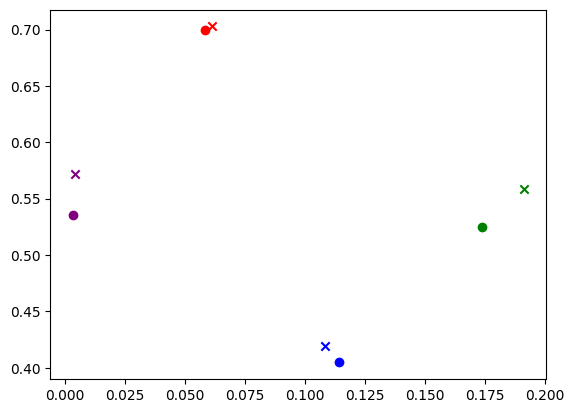

In [116]:
import matplotlib.pyplot as plt

# Plot time taken as x, accuracy as y
plt.scatter(bdt_up_time, bdt_up_acc, label='UPENN', color='blue')
plt.scatter(bdt_ug_time, bdt_ug_acc, label='UGOT', color='green')
plt.scatter(bdt_am_time, bdt_am_acc, label='UPENN', color='red')
plt.scatter(bdt_pab_time, bdt_pab_acc, label='UPENN', color='purple')

plt.scatter(ovo_up_time, ovo_up_acc, label='UPENN', color='blue', marker='x')
plt.scatter(ovo_ug_time, ovo_ug_acc, label='UGOT', color='green', marker='x')
plt.scatter(ovo_am_time, ovo_am_acc, label='UPENN', color='red', marker='x')
plt.scatter(ovo_pab_time, ovo_pab_acc, label='UPENN', color='purple', marker='x')

plt.legend()

plt.show()